<img src="../media/LandingPage-Header-RED-CENTRE.jpg" alt="Notebook Banner" style="width:100%; height:auto; display:block; margin-left:auto; margin-right:auto;">

# Deploying Applications with Containers, Testing, and CI/CD

## Docker - Local Testing of Your Dockerized Application

This section provides a step by step guide on how to containerize your FastAPI application using Docker and test it locally. Docker allows you to package your application and its dependencies into a standardized unit called a container, ensuring that your application runs consistently across different environments.

### Purpose of This Example

The primary goal is to demonstrate the process of creating a Docker image for your FastAPI application and running it as a container for local testing. This is a crucial step before deploying your application to production environments. It covers:

1.  **Project Preparation:** Ensuring your project directory is correctly structured with all necessary files for Docker to build the image.
2.  **Building the Docker Image:** Using the `docker build` command to create a portable image of your application.
3.  **Running the Docker Container:** Launching your application inside a Docker container, mapping necessary ports to access it from your host machine.
4.  **Local Testing:** Verifying that your FastAPI application is accessible and functional within the Docker container.
5.  **Cleanup Best Practices:** Instructions on how to stop and remove containers and images to manage resources effectively.

This process is fundamental for achieving reproducibility and consistency in your application deployments.

### Prerequisites

Before proceeding, ensure you have Docker installed and running on your local machine. You can download Docker Desktop from the official Docker website.

### Step by Step Guide for Local Docker Testing

**Step 1: Prepare Your Project Directory**

Ensure that all the files and directories mentioned in your Dockerfile are present in the same directory as your Dockerfile. This is crucial because the `COPY` commands rely on these files existing in the "build context" (the directory where your Dockerfile resides).

You should have the following files/directories in your project root:

-   `Dockerfile` (the definition of your Docker image)
-   `requirements.txt` (listing Python dependencies like `fastapi`, `uvicorn`, `mlflow`, `pandas`, etc.)
-   `app.py` (your main FastAPI application file, or `app_flexible.py` if you used that name in the previous step)
-   A directory named `src/` (containing `config.py` and other modules, if your project structure includes it)
-   A directory named `model_store/` (containing your trained model, e.g., `churn_prediction_model_v1.joblib` or any other model artifact your `app.py` loads).

Make sure your current working directory in your terminal is the one containing all these files.

**Step 2: Build the Docker Image**

This command reads your `Dockerfile` and creates a Docker image, which is a lightweight, standalone, executable package of your application.

-   Open your terminal or command prompt.
-   Navigate to the directory where your `Dockerfile` is located.
-   Run the following command:
    ```bash
    docker build -t churn-fastapi-app .
    ```
    * `docker build`: This is the command to build a Docker image.
    * `-t churn-fastapi-app`: This tags your image with a name (`churn-fastapi-app`). You can choose any meaningful name. This name will be used to reference the image later.
    * `.`: This specifies the build context, meaning Docker will look for the `Dockerfile` and all referenced files in the current directory.

You will see output in your terminal as Docker executes each step defined in your `Dockerfile`. If successful, it will end with a message indicating the image was built.

**Step 3: Run the Docker Container**

Once the image is built, you can run a container from it. A container is a running instance of an image.

-   In your terminal, run the following command:
    ```bash
    docker run -p 8000:8000 --name churn-fastapi-app-instance churn-fastapi-app
    ```
    * `docker run`: This command starts a new container.
    * `-p 8000:8000`: This is crucial for local testing. It maps port `8000` on your host machine (your computer) to port `8000` inside the Docker container. Your `Dockerfile` exposes port `8000`, and your `CMD` command runs Uvicorn on port `8000` inside the container. This mapping allows you to access the app from your browser.
    * `--name churn-fastapi-app-instance`: This gives your running container a memorable name (`churn-fastapi-app-instance`). This is optional but very useful for stopping or removing it later. You can use `docker ps` to see running containers and their names/IDs.
    * `churn-fastapi-app`: This is the name of the Docker image you built in Step 2.

The application will start running inside the container, and you should see Uvicorn's output in your terminal, indicating it's listening on `http://0.0.0.0:8000`.

**Step 4: Test Your FastAPI Application**

Now that your container is running, you can access your FastAPI application from your web browser or using tools like `curl`.

-   Open your web browser.
-   Go to: `http://localhost:8000/docs`

This will show you all your defined API endpoints and allow you to test them directly from the browser using Swagger UI.

**Step 5: Stop and Clean Up (Good Practice)**

Once you've finished testing, it's good practice to stop and remove the container to free up resources.

-   **To stop the container:**
    * If you ran it in the foreground (without `-d`), go back to your terminal where the container is running and press `Ctrl+C`.
    * Alternatively, if you ran it in detached mode (with `-d`) or in another terminal: `docker stop churn-fastapi-app-instance` (Replace `churn-fastapi-app-instance` with your container's name or ID from `docker ps`).

-   **To remove the container (after stopping):**
    ```bash
    docker rm churn-fastapi-app-instance
    ```

-   **To remove the Docker image (if you no longer need it):**
    ```bash
    docker rmi churn-fastapi-app
    ```
    (This will only work if no containers are currently using the image).

By following these steps, you can effectively build and test your Dockerized FastAPI application locally.

### Example Dockerfile

Below is an example of a `Dockerfile` that you would place in your project's root directory. This `Dockerfile` defines the steps to build your Docker image.

```dockerfile
# Dockerfile
# Use an official Python runtime as a parent image. This provides a base operating system
# with Python pre-installed, making the image lightweight and efficient.
FROM python:3.11-slim-buster
# Using Python 3.11 for compatibility.

# Set the working directory inside the container to /app.
# All subsequent commands (like COPY, RUN, CMD) will be executed relative to this directory.
WORKDIR /app

# Copy the requirements.txt file from your host machine into the container at /app.
# This step is done early to leverage Docker's build cache.
COPY requirements.txt .

# Install any needed Python packages specified in requirements.txt.
# --no-cache-dir: Prevents pip from storing cache, reducing the final image size.
# -r: Installs packages listed in the requirements file.
RUN pip install --no-cache-dir -r requirements.txt

# Copy the main FastAPI application file (e.g., app.py or app_flexible.py) into the container at /app.
COPY app.py /app/

# Copy the 'src' directory (if it exists) containing config.py and other custom modules.
# This is crucial for resolving Python imports like 'from src import config'.
COPY src/ /app/src/

# Copy the 'model_store' directory containing your trained model artifacts.
# Ensure that 'model_store/churn_prediction_model_v1.joblib' (or your actual model file)
# exists in your host machine's project directory before building the Docker image.
COPY model_store/ /app/model_store/

# Expose port 8000. This informs Docker that the container listens on the specified network port
# at runtime. It doesn't actually publish the port; it's documentation and can be used by other tools.
EXPOSE 8000

# Command to run the application using Uvicorn when the container starts.
# 'app:app' refers to the 'app' object inside 'app.py' (or 'app_flexible.py').
# '--host 0.0.0.0' makes the server accessible from outside the container (from any IP address).
# '--port 8000' specifies the port Uvicorn listens on inside the container.
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "8000"]
```

# Testing Machine Learning Deployments

## Comprehensive Testing Strategy for FastAPI ML Applications

Testing is a critical phase in the development and deployment of machine learning applications, ensuring that models perform as expected and that the API serving them is robust and reliable. This section outlines a comprehensive testing strategy that includes unit, integration, functional, and end to end (E2E) tests.

### Purpose of This Section

The primary goal is to demonstrate how to build a testing suite that validates different layers of your ML application:

1.  **Unit Tests:** Focusing on isolated components, such as data models (Pydantic schemas) and utility functions, to ensure their internal logic is sound.
2.  **Integration Tests:** Verifying the interaction between different components, particularly between the FastAPI API and the loaded machine learning model, ensuring the end to end prediction flow works correctly.
3.  **Functional Tests:** Validating the API's behavior from a user's perspective, often by mocking external dependencies like the ML model to ensure correct routing, request/response handling, and error management.
4.  **End to End (E2E) Tests:** Testing the entire system as a whole in a production like environment, including the Docker container, FastAPI server, network layer, and the actual machine learning model, to verify full system functionality.

This layered approach helps in identifying and isolating bugs early in the development cycle, leading to more stable and maintainable deployments.

### Prerequisites

Ensure you have `pytest` (or `unittest` as used here) and `fastapi[all]` (which includes `TestClient`) installed:
```bash
pip install pytest "fastapi[all]" # or pip install unittest for standard library
```

Also, ensure your project structure allows for correct imports. The provided test scripts assume a structure where `app.py` is in the parent directory of `ml_project/tests/`.

### Unit Test: `test_api_unit.py`

**Objective:** This unit test module is designed to verify the correctness of the `ChurnPredictRequest` Pydantic model (or `TitanicPassenger` in our case, assuming the user's `app.py` has been updated to use `ChurnPredictRequest` as per the test code), which is used in your API to define the structure and data types of incoming prediction requests. The key purpose is to ensure that this data model correctly validates incoming data accepting valid data and rejecting invalid data in complete isolation from the FastAPI server or the machine learning model.

**Tests Performed:**

* `test_churn_predict_request_validation_success`: Verifies that valid data correctly validates against the Pydantic model.
* `test_churn_predict_request_validation_failure_invalid_type`: Tests that the Pydantic model raises an error for incorrect data types.
* `test_churn_predict_request_validation_failure_missing_field`: Tests that the Pydantic model raises an error for missing required fields.

**How to Run:**

1.  Save the code below as `test_api_unit.py` inside a `tests/` directory within your project (e.g., `your_project/tests/test_api_unit.py`).
2.  Ensure your `app.py` file (containing the `ChurnPredictRequest` or `TitanicPassenger` Pydantic model) is in the parent directory of `tests/`.
3.  From your project's root directory, run:
    ```bash
    python -m unittest tests/test_api_unit.py
    ```
    or if using `pytest`:
    ```bash
    pytest tests/test_api_unit.py
    ```

This will execute the unit tests and report their success or failure.

In [ ]:
# ml_project/tests/test_api_unit.py
"""
Objective:
    Unit tests specifically for the FastAPI application's Pydantic models
    and any small, isolated utility functions within app.py,
    implemented using Python's built in `unittest` framework.
    It focuses on validating data structures and basic logic in isolation,
    without interacting with the FastAPI server or the ML model's prediction logic.

Tests Performed:
    - test_churn_predict_request_validation_success:
        Verifies that valid data correctly validates against the Pydantic model.
    - test_churn_predict_request_validation_failure_invalid_type:
        Tests that the Pydantic model raises an error for incorrect data types.
    - test_churn_predict_request_validation_failure_missing_field:
        Tests that the Pydantic model raises an error for missing required fields.
"""
import unittest
import os
import sys
from pydantic import ValidationError # Specific exception for Pydantic validation

# Add the project root to sys.path to allow imports from app.py
# Assumes test_api_unit.py is in 'ml_project/tests/'
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..')))

# IMPORTANT: Replace ChurnPredictRequest with TitanicPassenger if that's the name in your app.py
from app import ChurnPredictRequest # Import the Pydantic model


class TestChurnPredictRequest(unittest.TestCase):

    def setUp(self):
        """
        Set up common valid prediction data for tests.
        This data should match the expected schema of your Pydantic model.
        """
        self.valid_prediction_data = {
            "gender": "Male",
            "SeniorCitizen": 0,
            "Partner": "No",
            "Dependents": "No",
            "tenure": 1,
            "PhoneService": "No",
            "MultipleLines": "No phone service",
            "InternetService": "DSL",
            "OnlineSecurity": "No",
            "OnlineBackup": "Yes",
            "DeviceProtection": "No",
            "TechSupport": "No",
            "StreamingTV": "No",
            "StreamingMovies": "No",
            "Contract": "Month-to-month",
            "PaperlessBilling": "Yes",
            "PaymentMethod": "Electronic check",
            "MonthlyCharges": 29.85,
            "TotalCharges": 29.85
        }
        print("\n--- Setup: Valid prediction data prepared ---")

    def test_churn_predict_request_validation_success(self):
        """Test that valid data correctly validates against the Pydantic model."""
        print("\n--- Test: Valid data validation success ---")
        # The test will fail automatically if a ValidationError is raised here,
        # which is the desired behavior for a success test.
        request_model = ChurnPredictRequest(**self.valid_prediction_data)

        # Assert that the data was loaded correctly into the model's attributes.
        self.assertEqual(request_model.gender, "Male")
        self.assertEqual(request_model.tenure, 1)
        self.assertEqual(request_model.TotalCharges, 29.85)
        print("Pydantic model successfully validated with valid data.")
        print("--- Test Complete ---")

    def test_churn_predict_request_validation_failure_invalid_type(self):
        """Test Pydantic model raises error for incorrect data types."""
        print("\n--- Test: Validation failure - invalid type ---")
        invalid_data = self.valid_prediction_data.copy()
        invalid_data["tenure"] = "not_an_int" # Introduce a type mismatch

        with self.assertRaises(ValidationError) as cm:
            ChurnPredictRequest(**invalid_data)

        # Check if the error message contains a relevant type error message
        error_message = str(cm.exception)
        self.assertIn("Input should be a valid integer", error_message)
        print(f"Pydantic model correctly raised ValidationError for invalid type: {error_message.splitlines()[0]}")
        print("--- Test Complete ---")

    def test_churn_predict_request_validation_failure_missing_field(self):
        """Test Pydantic model raises error for missing required fields."""
        print("\n--- Test: Validation failure - missing field ---")
        invalid_data = self.valid_prediction_data.copy()
        del invalid_data["gender"] # Remove a required field

        with self.assertRaises(ValidationError) as cm:
            ChurnPredictRequest(**invalid_data)

        # Check if the error message contains a relevant missing field message
        error_message = str(cm.exception)
        self.assertIn("Field required", error_message)
        self.assertIn("gender", error_message)
        print(f"Pydantic model correctly raised ValidationError for missing field: {error_message.splitlines()[0]}")
        print("--- Test Complete ---")


if __name__ == '__main__':
    unittest.main()

### Integration Test: `test_api_integration.py`

**Objective:** This integration test module is designed to verify that the API layer (built with FastAPI) and the machine learning model work together correctly. Its main purpose is to simulate real API calls and check if the application behaves as expected, from receiving a request to returning a valid prediction from the actual, loaded model.

**Tests Performed:**

* `test_predict_endpoint_with_real_model_success`: Verifies that the `/predict` endpoint returns a `200` status code and a valid prediction structure for a typical input, using the actual loaded model.
* `test_predict_endpoint_validation_failure`: Verifies that the `/predict` endpoint correctly handles invalid input data by returning a `422` status code (Unprocessable Entity).
* `test_predict_endpoint_with_real_model_edge_case_input`: Tests the `/predict` endpoint with an edge case input to ensure robustness.

**How to Run:**

1.  Save the code below as `test_api_integration.py` inside the same `tests/` directory (e.g., `your_project/tests/test_api_integration.py`).
2.  Ensure your `app.py` file is in the parent directory of `tests/` and that the `MODEL_PATH` (or `MLFLOW_RUN_ID` and `MODEL_ARTIFACT_PATH` if using MLflow `load_model`) in `app.py` points to a valid, existing model file.
3.  From your project's root directory, run:
    ```bash
    python -m unittest tests/test_api_integration.py
    ```
    or if using `pytest`:
    ```bash
    pytest tests/test_api_integration.py
    ```

These tests will spin up a test instance of your FastAPI application, send requests to it, and assert on the responses, providing confidence in your API's functionality.

In [ ]:
# ml_project/tests/test_api_integration.py
"""
Objective:
    Integration tests for the FastAPI application, implemented using Python's
    built-in `unittest` framework and FastAPI's `TestClient`.
    It focuses on validating the interaction between the FastAPI API endpoints
    and the actual, loaded machine learning model. These tests ensure that
    the model is correctly loaded and can make valid predictions based on
    the data received through the API, verifying the end-to-end data flow
    from API request parsing to model inference.

Tests Performed:
    - test_predict_endpoint_with_real_model_success:
        Verifies that the /predict endpoint returns a 200 status code and
        a valid prediction structure for a typical input, using the actual loaded model.
    - test_predict_endpoint_validation_failure:
        Verifies that the /predict endpoint correctly handles invalid input data
        by returning a 422 status code (Unprocessable Entity).
    - test_predict_endpoint_with_real_model_edge_case_input:
        Tests the /predict endpoint with an edge case input to ensure robustness.
"""
import unittest
import os
import sys
import json # Used if loading data from a file for fixtures, though here it's direct dicts

# Import TestClient and app from FastAPI
from fastapi.testclient import TestClient

# Add the project root to sys.path to allow imports from app.py
# Assumes test_api_integration.py is in 'ml_project/tests/'
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..')))

# Import app and MODEL_PATH to check if the real model is loaded
# IMPORTANT: If you used MLflow's load_model in app.py, you might need to adjust
# how you check for model loading, as app.state might not be directly used.
# For MLflow, app.on_event("startup") handles it. This test assumes app.py
# stores the loaded model in `app.state.model_pipeline`.
from app import app, MODEL_PATH # Assuming MODEL_PATH is defined in app.py for the model file


class TestAPIIntegration(unittest.TestCase):

    # Class-level setup for the TestClient, equivalent to pytest fixture(scope="module")
    @classmethod
    def setUpClass(cls):
        """
        Set up the FastAPI TestClient once for all tests in this class.
        Also, verifies that the model is loaded during app startup.
        """
        print("\n--- Integration Test Setup: Initializing FastAPI TestClient and checking model ---")
        # Initialize TestClient and manually trigger the app's startup events
        cls.client = TestClient(app)
        cls.client.__enter__() # Manually enter the context manager for startup events

        # Verify that the model pipeline is loaded. This check depends on how app.py handles model loading.
        # If app.py uses @app.on_event("startup") to load a model into a global variable,
        # you might need to adjust this check (e.g., check the global variable directly).
        # This assumes the model is stored in app.state.model_pipeline after startup.
        if not hasattr(app.state, "model_pipeline") or app.state.model_pipeline is None:
            # This will fail the test suite early if the model isn't loaded, as expected
            raise AssertionError(
                f"Integration test requires actual model loaded at {MODEL_PATH}. "
                "Please ensure the model file exists and is correctly loaded into app.state by app.py "
                "during application startup.")
        print("FastAPI TestClient initialized. Model confirmed to be loaded.")

        # Define valid and edge-case prediction data as class attributes
        # These should match the expected input schema of your API.
        cls.valid_prediction_data = {
            "gender": "Male", "SeniorCitizen": 0, "Partner": "No", "Dependents": "No",
            "tenure": 1, "PhoneService": "No", "MultipleLines": "No phone service",
            "InternetService": "DSL", "OnlineSecurity": "No", "OnlineBackup": "Yes",
            "DeviceProtection": "No", "TechSupport": "No", "StreamingTV": "No",
            "StreamingMovies": "No", "Contract": "Month-to-month",
            "PaperlessBilling": "Yes", "PaymentMethod": "Electronic check",
            "MonthlyCharges": 29.85, "TotalCharges": 29.85
        }

        cls.edge_case_prediction_data = {
            "gender": "Female", "SeniorCitizen": 1, "Partner": "Yes", "Dependents": "Yes",
            "tenure": 72, "PhoneService": "Yes", "MultipleLines": "Yes",
            "InternetService": "Fiber optic", "OnlineSecurity": "Yes", "OnlineBackup": "Yes",
            "DeviceProtection": "Yes", "TechSupport": "Yes", "StreamingTV": "Yes",
            "StreamingMovies": "Yes", "Contract": "Two year",
            "PaperlessBilling": "No", "PaymentMethod": "Credit card (automatic)",
            "MonthlyCharges": 118.75, "TotalCharges": 8684.8
        }
        print("Test data for integration tests prepared.")


    @classmethod
    def tearDownClass(cls):
        """
        Clean up resources after all tests in the class have run.
        """
        print("\n--- Integration Test Teardown: Shutting down FastAPI TestClient ---")
        # Manually trigger the app's shutdown events
        cls.client.__exit__(None, None, None) # Exit the context manager
        print("FastAPI TestClient resources cleaned up.")

    def test_predict_endpoint_with_real_model_success(self):
        """
        Tests the /predict endpoint with a real model using valid input,
        ensuring a 200 status code and expected prediction structure.
        """
        print("\n--- Test: /predict endpoint with valid input ---")
        response = self.client.post("/predict", json=self.valid_prediction_data)

        self.assertEqual(response.status_code, 200, f"Expected status code 200, got {response.status_code}")
        data = response.json()

        self.assertIn("prediction", data, "Response should contain 'prediction' key")
        # Adjust expected prediction values based on your model's actual output (e.g., 0/1 for Titanic)
        # Assuming 'Churn'/'No Churn' for the provided churn example
        self.assertIn(data["prediction"], ["Churn", "No Churn"], "Prediction should be 'Churn' or 'No Churn'")
        self.assertIn("no_churn_probability", data, "Response should contain 'no_churn_probability' key")
        self.assertIsInstance(data["no_churn_probability"], float, "no_churn_probability should be a float")
        self.assertIn("churn_probability", data, "Response should contain 'churn_probability' key")
        self.assertIsInstance(data["churn_probability"], float, "churn_probability should be a float")
        self.assertGreaterEqual(data["no_churn_probability"], 0.0)
        self.assertLessEqual(data["no_churn_probability"], 1.0)
        self.assertGreaterEqual(data["churn_probability"], 0.0)
        self.assertLessEqual(data["churn_probability"], 1.0)
        print("'/predict' endpoint with valid input tested successfully.")
        print(f"Response: {data}")
        print("--- Test Complete ---")

    def test_predict_endpoint_validation_failure(self):
        """
        Tests the /predict endpoint with invalid input data to ensure
        it returns a 422 status code (Unprocessable Entity).
        """
        print("\n--- Test: /predict endpoint validation failure ---")
        invalid_data = self.valid_prediction_data.copy()
        invalid_data["tenure"] = "not_an_integer" # Introduce an invalid data type

        response = self.client.post("/predict", json=invalid_data)

        self.assertEqual(response.status_code, 422, f"Expected status code 422 for invalid data, got {response.status_code}")
        data = response.json()
        self.assertIn("detail", data, "Error response should contain 'detail' key")
        self.assertIsInstance(data["detail"], list, "'detail' should be a list of errors")
        self.assertGreater(len(data["detail"]), 0, "Error detail list should not be empty")
        self.assertIn("Input should be a valid integer", str(data["detail"]), "Error message should indicate invalid type")
        print("'/predict' endpoint correctly handled invalid input with 422 status.")
        print(f"Response: {data}")
        print("--- Test Complete ---")

    def test_predict_endpoint_with_real_model_edge_case_input(self):
        """
        Tests the /predict endpoint with a real model using an edge case or
        potentially challenging input to ensure robustness.
        """
        print("\n--- Test: /predict endpoint with edge case input ---")
        response = self.client.post("/predict", json=self.edge_case_prediction_data)

        self.assertEqual(response.status_code, 200, f"Expected status code 200, got {response.status_code}")
        data = response.json()
        self.assertIn("prediction", data)
        self.assertIn(data["prediction"], ["Churn", "No Churn"])
        self.assertIn("no_churn_probability", data)
        self.assertIsInstance(data["no_churn_probability"], float)
        print("'/predict' endpoint with edge case input tested successfully.")
        print(f"Response: {data}")
        print("--- Test Complete ---")


if __name__ == '__main__':
    unittest.main()

### Functional Test: `test_api_functional.py`

**Objective:** The main goal of functional tests is to verify the "function" of your API endpoints from a user's perspective. This means checking that for a given request, the API returns the correct HTTP status code and a properly formatted response body.

To do this quickly and reliably, these tests isolate the API layer by replacing the actual, complex machine learning model with a "mock" or "stunt double." This allows you to test the API's routing, request parsing, response generation, and error handling without depending on the potentially slow or resource intensive machine learning model.

**Tests Performed:**

* `test_predict_endpoint_success`: Verifies that the `/predict` endpoint returns a `200` status code and a valid prediction structure when the model is loaded and returns a mock prediction.
* `test_predict_endpoint_model_not_loaded`: Ensures the `/predict` endpoint handles the scenario where the ML model is not yet loaded, returning a `503` status code.
* `test_predict_endpoint_invalid_input_data`: Tests that the `/predict` endpoint returns a `422` status code for missing required fields in the input.
* `test_predict_endpoint_incorrect_data_type`: Tests that the `/predict` endpoint returns a `422` status code for incorrect data types in the input fields.
* `test_predict_endpoint_model_prediction_error`: Verifies that the `/predict` endpoint gracefully handles exceptions originating from the underlying model's prediction method, returning a `500` status.

**How to Run:**

1.  Save the code below as `test_api_functional.py` inside your `tests/` directory (e.g., `your_project/tests/test_api_functional.py`).
2.  Ensure your `app.py` file is in the parent directory of `tests/`.
3.  From your project's root directory, run:
    ```bash
    python -m unittest tests/test_api_functional.py
    ```
    or if using `pytest`:
    ```bash
    pytest tests/test_api_functional.py
    ```

These tests will help ensure the API's behavior is correct regardless of the underlying model's specific output, focusing purely on the API's contract.

In [ ]:
# ml_project/tests/test_api_functional.py
"""
Objective:
    Functional tests for the FastAPI application's API endpoints,
    implemented using Python's built-in `unittest` framework and FastAPI's `TestClient`.
    It focuses on verifying that each endpoint (`/predict`) behaves as expected
    given specific inputs, returning correct HTTP status codes and response bodies.
    The ML model's prediction logic is typically mocked in these tests to isolate
    the API's routing and response handling from the model's internal logic.

Tests Performed:
    - test_predict_endpoint_success:
        Verifies that the /predict endpoint returns a 200 status code and
        a valid prediction structure when the model is loaded and returns a mock prediction.
    - test_predict_endpoint_model_not_loaded:
        Ensures the /predict endpoint handles the scenario where the ML model
        is not yet loaded, returning a 503 status code.
    - test_predict_endpoint_invalid_input_data:
        Tests that the /predict endpoint returns a 422 status code for missing
        required fields in the input.
    - test_predict_endpoint_incorrect_data_type:
        Tests that the /predict endpoint returns a 422 status code for incorrect
        data types in the input fields.
    - test_predict_endpoint_model_prediction_error:
        Verifies that the /predict endpoint gracefully handles exceptions
        originating from the underlying model's prediction method, returning a 500 status.
"""
import unittest
import os
import sys
from unittest.mock import MagicMock, patch

from fastapi.testclient import TestClient

# Add the project root to sys.path to allow imports from app.py
# Assumes test_api_functional.py is in 'ml_project/tests/'
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..')))

# Import app as app_module to patch its internal attributes more easily if needed,
# and also import the app instance directly.
import app as app_module
from app import app # Import the FastAPI app instance


class TestAPIFunctional(unittest.TestCase):

    # Class-level setup for the TestClient
    @classmethod
    def setUpClass(cls):
        """
        Set up the FastAPI TestClient once for all tests in this class.
        """
        print("\n--- Functional Test Setup: Initializing FastAPI TestClient ---")
        # Initialize TestClient and manually trigger the app's startup events
        cls.client = TestClient(app)
        cls.client.__enter__()
        # Define common valid prediction data
        cls.valid_prediction_data = {
            "gender": "Male", "SeniorCitizen": 0, "Partner": "No", "Dependents": "No",
            "tenure": 1, "PhoneService": "No", "MultipleLines": "No phone service",
            "InternetService": "DSL", "OnlineSecurity": "No", "OnlineBackup": "Yes",
            "DeviceProtection": "No", "TechSupport": "No", "StreamingTV": "No",
            "StreamingMovies": "No", "Contract": "Month-to-month",
            "PaperlessBilling": "Yes", "PaymentMethod": "Electronic check",
            "MonthlyCharges": 29.85, "TotalCharges": 29.85
        }
        print("FastAPI TestClient initialized. Valid prediction data prepared.")

    @classmethod
    def tearDownClass(cls):
        """
        Clean up resources after all tests in the class have run.
        """
        print("\n--- Functional Test Teardown: Shutting down FastAPI TestClient ---")
        # Manually trigger the app's shutdown events
        cls.client.__exit__(None, None, None)
        print("FastAPI TestClient resources cleaned up.")

    def setUp(self):
        """
        Set up a fresh mock for the model pipeline before each test.
        This ensures tests are isolated from each other's changes to the mock.
        """
        print("--- Per-test Setup: Setting up mock model pipeline ---")
        # Create a mock pipeline object for each test
        self.mock_pipeline = MagicMock()
        # Configure mock with predictable output for successful prediction tests
        self.mock_pipeline.predict.return_value = [1] # Predicts 'Churn'
        self.mock_pipeline.predict_proba.return_value = [[0.210779946276635, 0.789220053723365]] # [P(No Churn), P(Churn)]

        # Use patch.object to replace the model in the app's state.
        # self.addCleanup ensures that the patch is automatically stopped after the test.
        patcher = patch.object(app_module.app.state, 'model_pipeline', self.mock_pipeline)
        patcher.start()
        self.addCleanup(patcher.stop)
        print("Mock model pipeline set as app.state.model_pipeline.")


    def test_predict_endpoint_success(self):
        """
        Test /predict endpoint with valid data when the model is mocked
        to return a successful prediction.
        """
        print("\n--- Test: /predict endpoint success with mocked model ---")
        response = self.client.post("/predict", json=self.valid_prediction_data)

        self.assertEqual(response.status_code, 200, f"Expected status 200, got {response.status_code}")
        data = response.json()

        self.assertIn("prediction", data)
        self.assertEqual(data["prediction"], "Churn") # Based on mock_pipeline.predict.return_value
        self.assertIn("no_churn_probability", data)
        self.assertIsInstance(data["no_churn_probability"], float)
        self.assertIn("churn_probability", data)
        self.assertIsInstance(data["churn_probability"], float)
        self.assertEqual(data["no_churn_probability"], 0.210779946276635)
        self.assertEqual(data["churn_probability"], 0.789220053723365)
        self.mock_pipeline.predict.assert_called_once()
        self.mock_pipeline.predict_proba.assert_called_once()
        print("'/predict' endpoint tested successfully with mocked model.")
        print(f"Response: {data}")
        print("--- Test Complete ---")

    def test_predict_endpoint_model_not_loaded(self):
        """
        Test /predict endpoint when the model pipeline is explicitly set to None.
        Should return 503 Service Unavailable.
        """
        print("\n--- Test: /predict endpoint - model not loaded ---")
        app_module.app.state.model_pipeline = None # Simulate model not being loaded

        response = self.client.post("/predict", json=self.valid_prediction_data)

        self.assertEqual(response.status_code, 503, f"Expected status 503, got {response.status_code}")
        data = response.json()
        self.assertIn("detail", data)
        self.assertEqual(data["detail"], "Model not loaded yet.")
        print("'/predict' endpoint correctly returned 503 when model not loaded.")
        print(f"Response: {data}")
        print("--- Test Complete ---")

    def test_predict_endpoint_invalid_input_data(self):
        """Test /predict endpoint with missing required field."""
        print("\n--- Test: /predict endpoint - invalid input (missing field) ---")
        invalid_data = self.valid_prediction_data.copy()
        del invalid_data["gender"] # Missing required field

        response = self.client.post("/predict", json=invalid_data)

        self.assertEqual(response.status_code, 422, f"Expected status 422, got {response.status_code}")
        data = response.json()
        self.assertIn("detail", data)
        self.assertIsInstance(data["detail"], list)
        self.assertIn("Field required", str(data["detail"]))
        self.assertIn("gender", str(data["detail"]))
        print("'/predict' endpoint correctly returned 422 for missing field.")
        print(f"Response: {data}")
        print("--- Test Complete ---")

    def test_predict_endpoint_incorrect_data_type(self):
        """Test /predict endpoint with wrong data type for field."""
        print("\n--- Test: /predict endpoint - invalid input (incorrect type) ---")
        invalid_data = self.valid_prediction_data.copy()
        invalid_data["tenure"] = "one" # Incorrect type

        response = self.client.post("/predict", json=invalid_data)

        self.assertEqual(response.status_code, 422, f"Expected status 422, got {response.status_code}")
        data = response.json()
        self.assertIn("detail", data)
        self.assertIsInstance(data["detail"], list)
        self.assertIn("Input should be a valid integer", str(data["detail"]))
        print("'/predict' endpoint correctly returned 422 for incorrect data type.")
        print(f"Response: {data}")
        print("--- Test Complete ---")

    def test_predict_endpoint_model_prediction_error(self):
        """Test /predict if the model.predict method raises an error."""
        print("\n--- Test: /predict endpoint - model prediction error ---")
        # Configure the mock model to raise an exception during prediction
        self.mock_pipeline.predict.side_effect = Exception("Mock prediction error")
        # Ensure the app is using this mock
        app_module.app.state.model_pipeline = self.mock_pipeline

        response = self.client.post("/predict", json=self.valid_prediction_data)

        self.assertEqual(response.status_code, 500, f"Expected status 500, got {response.status_code}")
        data = response.json()
        self.assertIn("detail", data)
        # Check for a more specific error message that indicates a prediction failure
        self.assertIn("Prediction failed", data["detail"])
        self.assertIn("Mock prediction error", data["detail"])
        self.mock_pipeline.predict.assert_called_once()
        print("'/predict' endpoint correctly returned 500 for model prediction error.")
        print(f"Response: {data}")
        print("--- Test Complete ---")


if __name__ == '__main__':
    unittest.main()

### End to End (E2E) Test: `test_e2e_suite.py`

**Objective:** The purpose of End to End (E2E) tests is to verify that your entire API application works correctly from start to finish in a production like environment. It tests the complete system as a whole, including the Docker container, the FastAPI server, the network layer, and the actual machine learning model.

These tests are the most comprehensive, as they validate the entire deployment pipeline, from containerization to live inference. They ensure that all components interact seamlessly and that the deployed application meets its functional requirements in a realistic setting.

**Tests Performed:**

* `test_e2e_predict_success`: Deploys the FastAPI app in Docker, makes a valid prediction request to its API, and asserts on the `200` status code and the structure/values of the prediction response.
* `test_e2e_predict_invalid_input`: Deploys the FastAPI app, makes a prediction request with invalid input, and asserts on the `422` status code and the error details.

**How to Run:**

1.  Save the code below as `test_e2e_suite.py` inside your `tests/` directory (e.g., `your_project/tests/test_e2e_suite.py`).
2.  Ensure you have a `Dockerfile`, `app.py`, `requirements.txt`, and your `model_store/` directory (with the model file) in your project's root directory, as these are needed for Docker to build the image.
3.  Ensure Docker Desktop or Docker Engine is running on your machine.
4.  From your project's root directory, run:
    ```bash
    python -m unittest tests/test_e2e_suite.py
    ```
    or if using `pytest`:
    ```bash
    pytest tests/test_e2e_suite.py
    ```

These tests will automatically build a Docker image, run a container, send HTTP requests, and then clean up the Docker resources, providing a full end to end validation of your deployment.

In [ ]:
# churn_classification_app_unittest/tests_unittest/test_e2e_suite.py
"""
Objective:
    End-to-End (E2E) tests for the deployed FastAPI application,
    implemented using Python's built-in `unittest` framework.
    It orchestrates the setup of a test environment, including:
    1. Verifying the existence of a pre-trained ML model on the host.
    2. Building a Docker image for the FastAPI app.
    3. Starting the Docker container based on the built image.
    4. Waiting for the API service to become reachable.
    5. Executing actual HTTP requests against the running service.
    6. Performing necessary cleanup (stopping/removing container, deleting Docker image).

    These tests verify the complete system behavior, including interaction with
    the actual loaded ML model and the network layer, mimicking a real-world scenario.

Tests Performed:
    - test_e2e_predict_success:
        Deploys the FastAPI app in Docker, makes a valid prediction request to its API,
        and asserts on the 200 status code and the structure/values of the prediction response.
    - test_e2e_predict_invalid_input:
        Deploys the FastAPI app, makes a prediction request with invalid input,
        and asserts on the 422 status code and the error details.
"""
import unittest
import requests
import time
import subprocess
import json
import os
from pathlib import Path
import sys
# shutil is no longer needed as we are not deleting model_store or log files
# from the host, but managing Docker artifacts.

# Add project root to sys.path
# Use pathlib for robust path handling
PROJECT_ROOT = Path(__file__).resolve().parent.parent.parent
sys.path.insert(0, str(PROJECT_ROOT)) # sys.path needs a string

# Import config for consistent paths (assuming src.config exists)
try:
    from src.config import MODEL_FILENAME, MODEL_STORE_DIR # LOG_FILENAME removed
except ImportError:
    # Fallback for testing if config is not strictly available or if we're in a strange env
    print("Warning: Could not import MODEL_FILENAME or MODEL_STORE_DIR from src.config. Using defaults.")
    MODEL_FILENAME = "churn_prediction_model_v1.joblib"
    MODEL_STORE_DIR = "model_store"


# Configuration for the E2E test
API_URL = "http://localhost:8000"
PREDICT_ENDPOINT = f"{API_URL}/predict"
DOCKER_IMAGE_NAME = "churn-api-e2e-test"
CONTAINER_NAME = "churn-api-e2e-container"
API_STARTUP_TIMEOUT = 120 # seconds for API to become reachable
API_HEALTH_CHECK_INTERVAL = 2 # seconds for checking health

# Paths for model relative to the project root on the HOST machine
MODEL_DIR = PROJECT_ROOT / MODEL_STORE_DIR
MODEL_PATH_FULL = MODEL_DIR / MODEL_FILENAME

# Sample data for a valid prediction request
sample_e2e_prediction_data = {
    "tenure": 1,
    "MonthlyCharges": 29.85,
    "TotalCharges": 29.85,
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "PhoneService": "No",
    "MultipleLines": "No phone service",
    "InternetService": "DSL",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check"
}


class TestE2ESuite(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        """
        Sets up the E2E test environment by:
        1. Verifying the pre-trained ML model exists on the host (prerequisite for Docker build).
        2. Builds the Docker image for the FastAPI app.
        3. Starts the Docker container.
        4. Waits for the API to be reachable (via /docs endpoint).
        """
        print("\n--- E2E Setup: Preparing environment and starting services ---")

        # 1. Verifying the pre-trained ML model exists on the host.
        # This is a prerequisite for the Docker build process to copy it.
        print("\n--- E2E Setup: Verifying Pre-trained Model on Host ---")
        if not MODEL_PATH_FULL.exists():
            raise AssertionError(
                f"Pre-trained model not found at {MODEL_PATH_FULL}. "
                "Please ensure the ML pipeline has been run and the model is saved to this location "
                "before running E2E tests, as it needs to be copied into the Docker image."
            )
        print(f"Using pre-trained model found on host at: {MODEL_PATH_FULL}")

        # Ensure no pre-existing container with the same name is running
        print("\n--- E2E Setup: Cleaning up any old container/image ---")
        subprocess.run(["docker", "stop", CONTAINER_NAME], check=False, capture_output=True, text=True)
        subprocess.run(["docker", "rm", CONTAINER_NAME], check=False, capture_output=True, text=True)
        subprocess.run(["docker", "rmi", DOCKER_IMAGE_NAME], check=False, capture_output=True, text=True)
        print("Ensured no pre-existing container or image with the same name.")


        # 2. Builds the Docker image for the FastAPI app.
        print("\n--- E2E Setup: Building Docker Image ---")
        try:
            # Build the Docker image from the project root (where Dockerfile, app.py, src/, model_store/ are)
            # check=True raises CalledProcessError if command returns non-zero exit status
            result = subprocess.run(["docker", "build", "-t", DOCKER_IMAGE_NAME, "."],
                                     check=True, cwd=PROJECT_ROOT, capture_output=True, text=True)
            print("Docker build stdout:\n", result.stdout)
            if result.stderr: # Only print stderr if there's actual content
                print("Docker build stderr:\n", result.stderr)
            print(f"Docker image '{DOCKER_IMAGE_NAME}' built successfully.")
        except subprocess.CalledProcessError as e:
            raise AssertionError(f"Docker image build failed. STDOUT: {e.stdout}\nSTDERR: {e.stderr}")
        except FileNotFoundError:
            raise AssertionError("Docker command not found. Is Docker installed and in your system's PATH?")


        # 3. Starts the Docker container.
        print("\n--- E2E Setup: Starting Docker Container ---")
        try:
            cmd = [
                "docker", "run", "-d", # Run in detached mode
                "--name", CONTAINER_NAME,
                "-p", "8000:8000", # Map host port 8000 to container port 8000
                DOCKER_IMAGE_NAME # Use the built image
            ]
            result = subprocess.run(cmd, capture_output=True, text=True, check=True)
            print(f"Container start stdout: {result.stdout}")
            if result.stderr: # Only print stderr if there's actual content
                print(f"Container start stderr: {result.stderr}")
            cls.container_id = result.stdout.strip()
            print(f"Container {cls.container_id} started.")

        except subprocess.CalledProcessError as e:
            print(f"Docker run failed. STDOUT: {e.stdout}\nSTDERR: {e.stderr}")
            cls.tearDownClass() # Attempt cleanup before raising
            raise AssertionError(f"Docker container failed to start: {e}")
        except Exception as e: # Catch any other run-related errors
            cls.tearDownClass() # Attempt cleanup before raising
            raise AssertionError(f"An unexpected error occurred during Docker container startup: {e}")

        # 4. Waits for the API to be reachable (e.g., by checking the /docs endpoint).
        print("Waiting for API to become reachable...")
        for i in range(API_STARTUP_TIMEOUT // API_HEALTH_CHECK_INTERVAL):
            try:
                # Use a higher timeout for the request itself, separate from total startup timeout
                response = requests.get(f"{API_URL}/docs", timeout=10)
                if response.status_code == 200:
                    print("API is reachable!")
                    break
            except requests.exceptions.ConnectionError as e:
                print(f"Connection error: {e}. Retrying...")
            except requests.exceptions.Timeout:
                print("Request timed out. Retrying...")
            except Exception as e: # Catch any other request-related errors
                print(f"An unexpected error occurred during health check: {e}. Retrying...")

            time.sleep(API_HEALTH_CHECK_INTERVAL)
        else: # This block runs if the loop completes without a 'break'
            # If the API did not become ready, get logs before failing.
            print("\n--- Docker Container Logs (from failed startup) ---")
            logs_result = subprocess.run(
                ["docker", "logs", CONTAINER_NAME],
                capture_output=True, text=True, check=False
            )
            print(logs_result.stderr + logs_result.stdout) # Print both stdout and stderr logs
            print("---------------------------------------------------\n")
            cls.tearDownClass() # Ensure cleanup before failing
            raise AssertionError(f"API did not become reachable within {API_STARTUP_TIMEOUT} seconds.")

        print("--- E2E Setup Complete ---")

    @classmethod
    def tearDownClass(cls):
        """
        Teardown for all E2E tests:
        1. Stop and remove the Docker container.
        2. Remove the Docker image.
        """
        print("\n--- E2E Teardown: Stopping services and cleaning up artifacts ---")

        # 1. Stop and remove Docker container
        if hasattr(cls, 'container_id') and cls.container_id:
            print(f"Stopping and removing Docker container: {CONTAINER_NAME} ({cls.container_id[:12]}) ...")
            subprocess.run(["docker", "stop", CONTAINER_NAME], check=False, capture_output=True, text=True)
            subprocess.run(["docker", "rm", CONTAINER_NAME], check=False, capture_output=True, text=True)
            print("Docker container stopped and removed.")

        # 2. Remove Docker image
        print(f"Removing Docker image: {DOCKER_IMAGE_NAME}...")
        try:
            # -f (force) is often useful for test cleanup to remove even if in use (though it shouldn't be)
            subprocess.run(["docker", "rmi", DOCKER_IMAGE_NAME, "-f"], check=False, capture_output=True, text=True)
            print("Docker image removed.")
        except Exception as e:
            print(f"Error during image removal: {e}") # Don't fail the test cleanup for this

        print("--- E2E Teardown Complete ---")


    def test_e2e_predict_success(self):
        """E2E test for the /predict endpoint with valid data, matching the provided output format."""
        print("\n--- Test: E2E /predict successful ---")
        response = requests.post(PREDICT_ENDPOINT, json=sample_e2e_prediction_data)

        self.assertEqual(response.status_code, 200, f"Expected status 200, got {response.status_code}. Response: {response.text}")
        data = response.json()

        # Assert prediction string
        self.assertIn("prediction", data)
        self.assertIn(data["prediction"], ["Churn", "No Churn"], "Prediction should be 'Churn' or 'No Churn'")

        # Assert direct probability keys
        self.assertIn("churn_probability", data)
        self.assertIsInstance(data["churn_probability"], float)
        self.assertGreaterEqual(data["churn_probability"], 0.0)
        self.assertLessEqual(data["churn_probability"], 1.0)

        self.assertIn("no_churn_probability", data)
        self.assertIsInstance(data["no_churn_probability"], float)
        self.assertGreaterEqual(data["no_churn_probability"], 0.0)
        self.assertLessEqual(data["no_churn_probability"], 1.0)

        # Assert the 'probabilities' dictionary
        self.assertIn("probabilities", data)
        self.assertIsInstance(data["probabilities"], dict)
        self.assertIn("No Churn", data["probabilities"])
        self.assertIn("Churn", data["probabilities"])
        self.assertIsInstance(data["probabilities"]["No Churn"], float)
        self.assertIsInstance(data["probabilities"]["Churn"], float)
        self.assertGreaterEqual(data["probabilities"]["No Churn"], 0.0)
        self.assertLessEqual(data["probabilities"]["No Churn"], 1.0)
        self.assertGreaterEqual(data["probabilities"]["Churn"], 0.0)
        self.assertLessEqual(data["probabilities"]["Churn"], 1.0)

        # Assert probabilities sum to ~1.0
        self.assertAlmostEqual(data["churn_probability"] + data["no_churn_probability"], 1.0, places=5)
        self.assertAlmostEqual(data["probabilities"]["No Churn"] + data["probabilities"]["Churn"], 1.0, places=5)


        print(f"E2E /predict successful. Response: {data}")
        print("--- Test Complete ---")


    def test_e2e_predict_invalid_input(self):
        """E2E test for /predict with invalid input."""
        print("\n--- Test: E2E /predict invalid input ---")
        invalid_data = sample_e2e_prediction_data.copy()
        invalid_data["tenure"] = "not_a_number" # Invalid type

        response = requests.post(PREDICT_ENDPOINT, json=invalid_data)
        self.assertEqual(response.status_code, 422, f"Expected status 422, got {response.status_code}. Response: {response.text}")
        data = response.json()
        self.assertIn("detail", data)
        # Check for a validation error related to the 'tenure' field being an invalid integer.
        self.assertTrue(
            any("valid integer" in err["msg"].lower() and err["loc"][-1] == "tenure"
                for err in data["detail"]),
            f"Expected validation error for 'tenure' field, got: {data['detail']}"
        )
        print(f"E2E /predict correctly handled invalid input. Response: {data}")
        print("--- Test Complete ---")


if __name__ == '__main__':
    unittest.main()

-----------------------------

# Deploying CI/CD pipeline in GitHub

To deploy CI/DC on GitHub the following configurations are needed:

- Establish a GitHub repository
- Create Your Workflow File: Create a new directory at the root of your repository called `.github/workflows`. Inside this directory, create a new `YAML` file. The name of this file will be the name of your workflow (e.g., `ml_pipeline.yml`, `model_deploy.yml`). This file is where you define the entire CI/CD process. E.g.,

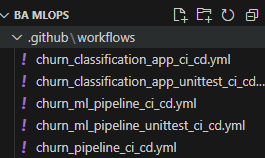

- Define Workflow Triggers (`on`): Within your YAML file, the first thing to configure is when the workflow should run. Example:
    - on: `push`: The workflow runs every time code is pushed to the repository (you can specify branches, e.g., branches: [main]).
    - on: `pull_request`: The workflow runs when a pull request is opened, synchronised, or re-opened.
    - on: `schedule`: You can set it to run at specific intervals, for instance, daily at a certain time to retrain a model.
    - on: `workflow_dispatch`: Allows for manual triggering from the "Actions" tab.

- Define Jobs (`jobs`): Workflows are made up of one or more "jobs." Each job runs on a separate virtual machine (called a "runner"). You'll define distinct jobs for different phases of your pipeline, e.g., `data_preprocessing`, `model_training`, `model_testing`, `model_deployment`. You specify the operating system for the runner, e.g., `runs-on: ubuntu-latest`.

- Define Steps within Jobs (`steps`): Each job consists of a sequence of "steps." These steps are individual tasks that are executed in order. Common Steps for ML CI/CD:

    - Checkout Code: Use the `actions/checkout@v4` Action to get your repository's code onto the runner.

    - Set up Environment: Use `actions/setup-python@v5` to configure the Python version required.

    - Install Dependencies: Run commands like `pip install -r requirements.txt` to install necessary libraries.

    - Run Scripts: Execute your Python scripts for data loading, feature engineering, model training, and evaluation (e.g., `python src/train_model.py`).

    - Run Tests: Execute unit tests, integration tests, and model performance tests (e.g., `pytest`).

    - Build/Push Docker Images: If you're containerising your model.


- Monitor Your Pipeline: Once configured, commit your YAML file to the repository. The workflow will trigger based on your defined `on` events. Go to the "Actions" tab in your GitHub repository. Here, you will see a list of all your workflow runs, their status (success, failure, in progress), and detailed logs for each step. This is your primary dashboard for observing the CI/CD process.

Here below an example of the YAML file for our project.


```
name: Churn Classification APP CI/CD (Unittest)

on:
  push:
    branches: [main]
    paths:
      - '02 Building & Integrating ML Pipelines/churn_classification_app_unittest/**'
  pull_request:
    branches: [main]
    paths:
      - '02 Building & Integrating ML Pipelines/churn_classification_app_unittest/**'

jobs:
  test:
    name: Run Unit, Integration, Functional, and E2E Tests
    runs-on: ubuntu-latest

    defaults:
      run:
        # Set the working directory to the project root within the repository
        working-directory: "02 Building & Integrating ML Pipelines/churn_classification_app_unittest"

    steps:
    - name: Checkout Repository
      uses: actions/checkout@v3

    - name: Set up Python 3.11
      uses: actions/setup-python@v4
      with:
        python-version: '3.11'

    - name: Install Dependencies
      run: |
        pip install -r requirements.txt

    - name: Run Unit Tests
      run: |
        # Run unit tests
        # Assumes pure unit tests are in 'tests/unit/'
        python -m unittest discover tests/unit -p "test_*.py"

    - name: Run Integration Tests
      run: |
        # Run integration tests
        # Assumes integration tests are in 'tests/integration/' and end with '_integration.py'
        python -m unittest discover tests/integration -p "test_*.py"

    - name: Run Functional Tests
      run: |
        # Run functional tests
        # Assumes functional tests are in 'tests/functional/'
        python -m unittest discover tests/functional -p "test_*.py"

    - name: Run E2E Tests
      run: |
        # Run E2E tests
        # Assumes E2E tests are in 'tests/e2e/'
        python -m unittest discover tests/e2e -p "test_*.py"

```

Here an example of the requirements.txt for this project:

```
# Core ML Libraries
pandas~=2.0.0      # For data manipulation and analysis
numpy~=1.24.0      # For numerical operations
scikit-learn~=1.2.0 # For machine learning models, preprocessing, and metrics
joblib~=1.2.0      # For saving and loading Python objects, especially scikit-learn models

```

### Pre Push CI/CD Checklist

Here's a checklist to run through before pushing your changes to the main branch, especially when that push is set to trigger your CI/CD pipeline on GitHub. This helps catch common issues before the automation kicks in.

- [ ] Code Clean: All local changes committed, no temporary or debug code.

- [ ] Tests Pass: All relevant local tests run successfully.

- [ ] Dependencies Current: requirements.txt updated and tested if needed.

- [ ] Docker Assets Valid: Dockerfile syntax is correct, and all files needed for the Docker build context (like app.py, src/, model_store/) are present.

- [ ] Local Docker Test Passed: Docker image builds successfully locally, Docker container runs correctly locally, a quick local end to end test against the running container confirms basic app functionality (e.g., hitting /docs or a core endpoint).

- [ ] Documentation Updated: README.md reflects any changes in usage or setup.

- [ ] Workflow Valid: CI/CD workflow files (.yml) are syntactically correct if modified.

- [ ] Clear Commit: Commit message concisely describes the changes.

- [ ] Final Review: Briefly checked all changes and confirming push to main.


After your checklist is complete:

- Prepare Changes: 

    - `git add .` (stages all your modified files)

    - `git commit -m "Your concise commit message"` (saves the changes locally with a note)

- Send to GitHub:

    - `git push origin main` (sends your committed changes to the main branch on GitHub)

- On GitHub, immediately after your push:

    - Your updated code appears in the repository.

    - GitHub Actions detects the change.

    - Your CI/CD workflow automatically starts running.

    - You can watch its progress and results in the "Actions" tab of your GitHub repository.


If no errors are detected... 

__Congratulations, you have deployed an ML CI/CD Process!__

## README.md

Serves as the front door to your project. It should be clear, comprehensive, and easy to navigate, allowing anyone (from a new collaborator to a future self) to quickly understand and engage with your work. `A good README.md` is like a clear project instruction manual and storefront. It should quickly tell you:

- What it is: A brief project summary and its purpose.

- How to set it up: Clear steps to get the code running locally, including dependencies (requirements.txt).

- How to use it: Examples and commands to run the main functionalities.

- What's inside (for ML): Basic info on the data and model, and key results.

- Who made it & how to contribute: Information for collaborators and contact.

- Legal bits: The project's license.

- Essentially, it answers "What is this?", "How do I get it working?", and "How do I use it?".


You can find an example of this file at the end of the notebook. 

# Customer Churn Prediction API with Comprehensive Testing

This project provides a production ready, containerized API for serving a customer churn prediction model. Built with FastAPI, it demonstrates MLOps best practices, including robust data validation with Pydantic and a comprehensive, layered testing strategy.

## Project Overview

The API exposes a `/predict` endpoint that accepts customer data, feeds it to a pre trained scikit-learn pipeline, and returns a churn prediction along with the associated probabilities.

The key highlight is the multi-layered test suite, which is structured to ensure code quality, reliability, and maintainability at every level of the application stack.

## Project Structure

The project is organized into a clear and modular structure:

```
churn_classification_app_unittest_training1/
├── model_store/
│   └── churn_prediction_model_v1.joblib  # Pre-trained model artifact
├── src/
│   └── config.py                         # Centralized configuration
├── tests/
│   ├── unit/
│   │   └── test_api_unit.py              # Tests Pydantic models in isolation
│   ├── integration/
│   │   └── test_api_integration.py       # Tests API interaction with the real model
│   ├── functional/
│   │   └── test_api_functional.py        # Tests API logic with a mocked model
│   └── e2e/
│       └── test_e2e.py                   # Tests the live, containerized application
├── app.py                                # FastAPI application logic
├── Dockerfile                            # Instructions to build the Docker image
└── requirements.txt                      # Project dependencies
```

## Key Concepts Demonstrated

*   **FastAPI**: For building the high performance, asynchronous API.
*   **Pydantic**: For robust, type hint based data validation and serialization at the API boundary.
*   **Docker**: For containerizing the application, its dependencies, and the ML model for consistent and reproducible deployments.
*   **Layered Testing Strategy**: The project implements a full spectrum of tests, reflecting the "Testing Pyramid":
    *   **Unit Tests**: Fast tests that verify the smallest piece of the API the Pydantic request model in complete isolation.
    *   **Integration Tests**: Verifies the "seam" between the API layer and the actual, loaded machine learning model to ensure they are compatible.
    *   **Functional Tests**: Checks the API's logic (routing, error handling, response formatting) by replacing the ML model with a mock, allowing for exhaustive testing of all API behaviors.
    *   **End-to-End (E2E) Tests**: The highest level of testing. It builds the Docker image, runs the container, and sends real HTTP requests to the live service to validate the entire system.

## Setup and Installation

### Prerequisites

1.  **Python 3.11+**
2.  **Docker Desktop**: Required for running the end to end tests.
3.  **Pre-trained Model**: This API requires a pre trained model file (`churn_prediction_model_v1.joblib`). Ensure this file is present in the `model_store/` directory. It can be generated by running the associated training pipeline project.

### Installation Steps

1.  **Clone the repository:**
    ```bash
    git clone <repository-url>
    cd churn_classification_app_unittest_training1
    ```

2.  **Create and activate a virtual environment (recommended):**
    ```bash
    python -m venv venv
    source venv/bin/activate  # On Windows, use `venv\Scripts\activate`
    ```

3.  **Install the dependencies:**
    ```bash
    pip install -r requirements.txt
    ```

## How to Run

### Running the API Locally

To run the FastAPI server locally for development, use `uvicorn`:

```bash
uvicorn app:app --reload
```

The API will be available at `http://127.0.0.1:8000`. You can access the interactive documentation (Swagger UI) at `http://127.0.0.1:8000/docs`.

### Running the Tests

The project uses Python's `unittest` framework. You can run all tests using the `discover` command from the project's root directory.

**Run all tests (excluding E2E, which requires Docker):**
```bash
python -m unittest discover -s tests -p "test_api_*.py" -v
```

**Run a specific type of test:**

*   **Unit Tests:**
    ```bash
    python -m unittest tests/unit/test_api_unit.py -v
    ```
*   **Integration Tests:**
    ```bash
    python -m unittest tests/integration/test_api_integration.py -v
    ```
*   **Functional Tests:**
    ```bash
    python -m unittest tests/functional/test_api_functional.py -v
    ```

*   **End-to-End Test (Requires Docker to be running):**
    ```bash
    python -m unittest tests/e2e/test_e2e.py -v
    ```

## API Endpoint

### `POST /predict`

This endpoint accepts customer data and returns a churn prediction.

**Request Body:**

```json
{
  "tenure": 1,
  "MonthlyCharges": 29.85,
  "TotalCharges": 29.85,
  "gender": "Female",
  "SeniorCitizen": 0,
  "Partner": "Yes",
  "Dependents": "No",
  "PhoneService": "No",
  "MultipleLines": "No phone service",
  "InternetService": "DSL",
  "OnlineSecurity": "No",
  "OnlineBackup": "Yes",
  "DeviceProtection": "No",
  "TechSupport": "No",
  "StreamingTV": "No",
  "StreamingMovies": "No",
  "Contract": "Month-to-month",
  "PaperlessBilling": "Yes",
  "PaymentMethod": "Electronic check"
}
```

**Success Response (200 OK):**

```json
{
  "prediction": "No Churn",
  "churn_probability": 0.0783,
  "no_churn_probability": 0.9217,
  "probabilities": {
    "No Churn": 0.9217,
    "Churn": 0.0783
  }
}
```

---

This project serves as a robust template for building, testing, and deploying ML powered APIs.

